In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

%matplotlib inline

sklearn caches downloaded datasets in `$HOME/scikit_learn_data`.

Datasets loaded by sklearn have a similar dictionary structure:
* `DESCR` key describing the dataset
* `data` key containing an array with one row per instance and one column per feature
* `target` containing an array with the labels

In [2]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml("mnist_784", version=1)
mnist.keys()

dict_keys(['target', 'feature_names', 'details', 'data', 'DESCR', 'categories', 'url'])

In [3]:
X, y = mnist["data"], mnist["target"]
print(X.shape, y.shape)

(70000, 784) (70000,)


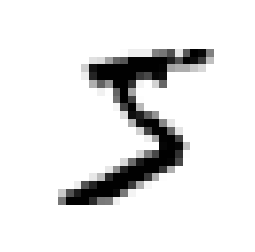

5


In [4]:
some_digit = X[0]
some_digit_image = some_digit.reshape(28,28)
plt.imshow(some_digit_image, cmap=mpl.cm.binary, interpolation="nearest")
plt.axis("off")
plt.show()
print(y[0])

In [5]:
# cast string to labels
y = y.astype(np.uint8)

The data set is already split into training and testing. The first 60,000 are training and the last 10,000 are testing.

In [6]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

## Training a Binary Classifier
Create a "5-detector."

In [7]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

Train using `SGDClassifier`. Note that `SGDClassifier` implements a linear model with SGD learning. The model in particular depends on `loss`. If `loss="hinge"`, then it trains a linear SVM and if `loss="log"`, then it trains a logistic regression.

We would use `SGDClassifier` in the case where we have a lot of data and when we need to do online learning.

In [8]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42, max_iter=100)
sgd_clf.fit(X_train, y_train_5)
sgd_clf.predict([some_digit])

/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


array([False])

## Performance Measures
Evaluating a classifier is often trickier than evaluating a regressor.
* Accuracy
* Confusion Matrix and Precision/Recall
* ROC Curve
May sometimes need to implement CV (see pg85).

In [9]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


array([0.97025, 0.95145, 0.9602 ])

95% accuracy looks good, but can be misleading.

In [10]:
from sklearn.base import BaseEstimator

# always predicts that it's not a 5
class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)
    
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.91125, 0.90855, 0.90915])

90% accuracy, this is because 10% of the data are 5s.

**Accuracy is not the preferred performance measure for classifiers, especially when the dataset is skewed (i.e. when some classes are much more frequent than others)**

#### Confusion Matrix
Displays the number of predicted results for a class against the instances' true class.

Use `cross_val_predict()` to return prediction of the validation instances from the model trained on that fold.
Each row in the confusion matrix represents an actual class, while each column represents a predicted class.

In this example, the first row considers non-5 images, where 53,272 of them were correctly classified as non-5s (**true negatives**), while the remaining 1,307 were wrongly classified as 5s (**false positive**). The second row considers images of 5s, where 1,077 were wrongly classified as non-5s (**false negatives**), while the remaining 4,344 were correctly classified as 5s (**true positive**).

* **True negative** - predict **NO** when it's actually **NO**
* **False positive** - predict **YES** when it's actually **NO**
* **False negatives** - predict **NO** when it's actually **YES**
* **True positive** - predict **YES** when it's actually **YES**

YES means that the attribute of interest we're predicting is present.

In [11]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)
confusion_matrix(y_train_5, y_train_pred)

/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


array([[53604,   975],
       [ 1387,  4034]])

* **Precision** - the **accuracy of positive predictions**, where we predict **YES**
$$
\frac{TP}{TP + FP}
$$

* **Recall** - the **ratio of positive instances** that are correctly detected by the classifier (i.e. how many correct **YES** out of all predicted **YES**). Also known as **sensitivty** or the **true positive rate**.
$$
\frac{TP}{TP + FN}
$$

In [12]:
from sklearn.metrics import precision_score, recall_score

pscore = precision_score(y_train_5, y_train_pred)
rscore = recall_score(y_train_5, y_train_pred)
print(pscore, rscore)

0.8053503693351967 0.7441431470208448


When predicting 5s, only 77% are correct and only detects 80% of the 5s.

* F1 score - [harmonic mean](https://towardsdatascience.com/on-average-youre-using-the-wrong-average-geometric-harmonic-means-in-data-analysis-2a703e21ea0) of precision and recall, which weighs both rates equally and emphasizes the impact of small outliers while minimizing the impact of large outliers, so as a result you will only get a high F1 score if both recall and precision are high
$$
2 * \frac{p*r}{p+r} = \frac{TP}{TP + \frac{FN + FP}{2}}
$$

In [13]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7735378715244488

F1 score is not always preferable. Depending on the scenario, we may want higher precision than recall or vvice versa. Also increasing precision reduces recall, and vice versa, this is the *precision/recall tradeoff*.

#### Precision/Recall Tradeoff
Given `SGDClassifier` for binary classification, some score (e.g. logits if using logistic regression or distance from hyperplane if using SVC... **[can get probability from this](https://scikit-learn.org/stable/modules/calibration.html)**) is computed and if that score is higher than a threshold, it assigns the instance to positive class, or else the negative class. Depending on the threshold, we may have a higher precision than recall, or higher recall than precision.

As we *increase* the threshold (e.g. make it more strict), we will **generally** have higher precision, but lower recall. As we *decrease* the threshold (e.g. make it more lenient), we will have lower precision, but higher recall.

We can call the classifier's `decision_function()` to return the score for each instance, and then make predictions based on those scores. `SGDClassifer` uses a default threshold of 0.

Note: `SGDClassifier` by default uses hinge loss, (i.e. it's an SVC) so we cannot directly get the probabilities since it does not construct a probability distribution, but rather a decision rule. We can still adjust the threshold, the distance.

In [14]:
y_scores = sgd_clf.decision_function([some_digit])
print(y_scores)

[-2866.61900497]


In [15]:
threshold = 0
y_some_pred = (y_scores > threshold)
print(y_some_pred)

[False]


In [16]:
threshold = 20000
y_some_pred = (y_scores > threshold)
print(y_some_pred)

[False]


How do we decide which threshold to use? Through cross validation by specifying we want it to return decision scores instead of predictions. Now we can compute the precision and recall for all possible thresholds using `precision_recall_curve()`. Then we can gauge which threshold gives us the precision and recall we desire.

In [17]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")

/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


In [18]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

In [19]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Prediction")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.xlabel("Threshold")
    plt.legend(loc="center left")
    plt.ylim([0,1])

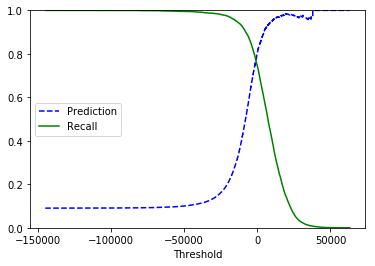

In [20]:
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

#### ROC Curve
The **receiver operating characteristic** curve is another curve used with binary classifiers.

It plots the *true positive* rate (recall or sensitivity -- how much positives we've classified out of all positives) against the *false positive rate*, that is, the ratio of negative instances that are incorrectly classified as positive. 

We use `roc_curve()` to compute the TPR and FPR for various threshold values.

Note: The *true negative rate* (specificty) is the ratio of negative instances that are correctly classified as negative. Thus, $FPR = 1 - TNR$.

In [21]:
from sklearn.metrics import roc_curve

fpr, tpr, threshoolds = roc_curve(y_train_5, y_scores)

In [22]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0,1], [0,1], "k--") # represents the ROC of a random classifier
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

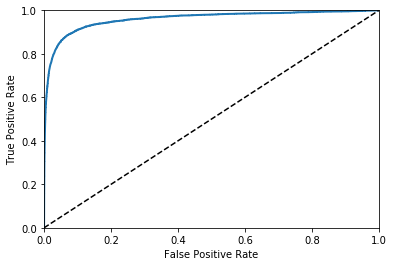

In [23]:
plot_roc_curve(fpr, tpr)
plt.show()

The dotted line represents the ROC curve of a purely random classifier. A good classifier hugs the top left corner of the graph.

**We can compare classifiers by measuring their area under the curve (AUC)**. A perfect classifer has *ROC AUC* equal to 1, whereas a purely random classifier has *ROC AUC* equal to 0.5.

In [24]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9599634584811508

#### ROC vs PR: Rule of Thumb
* Prefer PR whenever the positive class is rare or when you care more about false positives than false negatives
* Otherwise ROC

Models generally either have one of `decision_function()` or `predict_proba()`.

In [25]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,
                                       method="predict_proba")

/usr/local/lib/python3.5/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Since ROC curve needs scores and not probabilties, we can simply use just the positive class' probability as the score.

Note: `y_probas_forest` is m x 2.

In [26]:
y_scores_forest = y_probas_forest[:,1]
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

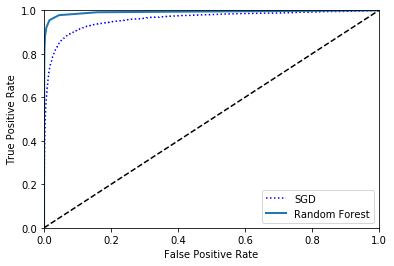

In [27]:
plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right")
plt.show()

In [28]:
roc_auc_score(y_train_5, y_scores_forest)

0.9920527492698306

## Multiclass Classification
* **one-vs-all** - Train a classifier for each class against all other classes. Select the class whose classifier outputs the highest score or probability.
* **one-vs-one** - Train a classifier for each pair and select the class with the most votes. If there are $N$ classes, then there are $\frac{N(N-1)}{2}$ classifiers. The advantage of this method is that each classifier only needs to be trained on the part of the training set for the two classes.
* Some algorithms such as SVM scale poorly with the size of the training set, so OvO is preferred.
* For binary classification, OvA is preferred.

In [29]:
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit]) # uses OvA

/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


array([3], dtype=uint8)

In [30]:
some_digit_scores = sgd_clf.decision_function([some_digit])
print(some_digit_scores)
print(np.argmax(some_digit_scores))
print(sgd_clf.classes_) # target classes are stored here

[[-16452.02382832 -32934.81594055 -13930.95879438   9433.96512015
  -41793.69914973   7001.24836964 -36148.61925326 -23636.17638294
  -35304.96978572 -19356.39286541]]
3
[0 1 2 3 4 5 6 7 8 9]


Can also force sklearn to use OvO or OvA by using `OneVsOneClassifier` or `OneVsRestClassifier` and passing in the classifier.

In [32]:
from sklearn.multiclass import OneVsOneClassifier, OneVsRestClassifier

ovo_clf = OneVsOneClassifier(SGDClassifier(random_state=42, max_iter=100)) # using OvO
ovo_clf.fit(X_train, y_train)
print(ovo_clf.predict([some_digit]))
print(len(ovo_clf.estimators_)) # number of classifiers trained

/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/

[5]
45


In [33]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


array([0.87442511, 0.87889394, 0.86683002])

In [34]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


array([0.90866827, 0.91069553, 0.91338701])

## Error Analysis
Assuming you've found your most promising model, how can we find ways to improve it?

We can begin by analyzing the errors it makes.

In [35]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


array([[5685,    1,   28,    8,   11,   51,   45,    7,   83,    4],
       [   1, 6457,   42,   31,    6,   45,    6,    8,  132,   14],
       [  35,   35, 5336,  102,   79,   29,   78,   46,  205,   13],
       [  36,   30,  135, 5338,    3,  232,   34,   47,  185,   91],
       [  16,   15,   44,   12, 5319,   10,   53,   31,  139,  203],
       [  54,   24,   38,  193,   61, 4605,   89,   20,  249,   88],
       [  31,   20,   43,    2,   42,   96, 5615,    5,   63,    1],
       [  22,   13,   68,   37,   55,    9,    3, 5766,   41,  251],
       [  33,   99,   59,  113,    6,  138,   44,   16, 5250,   93],
       [  30,   24,   32,   81,  134,   37,    2,  185,  140, 5284]])

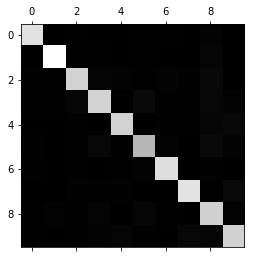

In [36]:
plt.matshow(conf_mx, cmap=plt.cm.gray)

Rather than looking at the absolute error, as shown above, look at the error rates.

**Recall, that the rows are predictions and the columns are the ground truth.** 

For example, row 0 predicts 0 and the columns are the ground truth of the predictions.

In [37]:
row_sums = conf_mx.sum(axis=1, keepdims=True) # column vector
norm_conf_mx = conf_mx / row_sums # broadcast column vector division across matrix (e.g. columnwise)

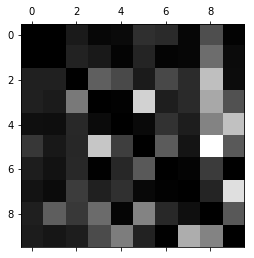

In [38]:
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

From the confusion matrix above, we see that rows 8 and 9 are quite bright. Also note that the errors are not symmetrical, for example, row 8, column 5 and row 5, column 8, where the latter has more mistakes.

By looking at the confusion matrix we should focus on fixing classes 8 and 9 and the confusion between 8,5 and 8,3.

## Multilabel Classification
* Multiple classes for each instance
* Binary classes

In [39]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7) # indicates whether 7, 8, or 9
y_train_odd = (y_train % 2 == 1) # indicates whether is odd
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [ ]:
knn_clf.predict([some_digit])

array([[False,  True]])

There are many ways to evaluate a multilabel classifier.
* We can compute the F1 score for each label and take the average over all labels (see `average='macro'`)
* We can also give more weight to the classifier's score on certain labels (see `average='weighted'`)

In [ ]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average="macro")

## Multioutput Classification
* Generalization of multilabel classification, where each label can be multiclass (more than 2 classes)
* Can also have a mix of class labels and value labels

## Exercises
#### 1. Build classifier that achieves over 97% on MNIST. Hint: use KNN.

In [8]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

knn_clf = KNeighborsClassifier()

knn_grid_params = {
    "n_neighbors": [4,5],
    "weights": ["uniform"],
    "algorithm": ["auto"]
}

grid_search = GridSearchCV(knn_clf, knn_grid_params, scoring="f1",
                           n_jobs=5, cv=3, verbose=2)
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


KeyboardInterrupt: 

In [ ]:
from sklearn.metrics import f1_score

best_knn_clf = grid_search.best_estimator_

y_preds = best_knn_clf.predict(X_test)
f1_score(y_test, y_preds)

In [ ]:
from sklearn.metrics import accuracy_score

accuracy_score(y_test, y_preds)

#### 2. Write a function that can shift an MNIST image in any direction by one pixel. For each image in the training set, create four shifted copies (one per direction) and add to the training set and train your model on this data set. Hint: use `shift()` from `scipy`.

In [9]:
from scipy.ndimage.interpolation import shift

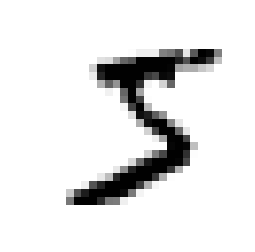

In [13]:
some_digit_shift_right = shift(some_digit.reshape(28,28), [0,1])

some_digit_image = some_digit_shift_right.reshape(28,28)
plt.imshow(some_digit_image, cmap=mpl.cm.binary, interpolation="nearest")
plt.axis("off")
plt.show()

In [14]:
def shift_image(image, dx, dy):
    image = image.reshape((28,28))
    shifted_image = shift(image, [dy, dx], cval=0, mode="constant")
    return shifted_image.reshape([-1])

In [25]:
from sklearn.base import BaseEstimator, TransformerMixin

class ShiftAugmentation(BaseEstimator):
    def __init__(self, shift_images=True, shift_by=1):
        self.shift_images = shift_images
        self.shift_by = shift_by
        
    def fit(self, X, y):
        return self
    
    def transform(self, X, y):
        if self.shift_images:
            X_augmented = [image for image in X]
            y_augmented = [label for label in y]
            
            directions = [(0,self.shift_by), (self.shift_by,0), 
                          (0,-self.shift_by), (-self.shift_by,0)]
            for image, label in zip(X, y):
                for dx, dy in directions:
                    X_augmented.append(shift_image(image,dx,dy))
                    y_augmented.append(label)
            
            return np.array(X_augmented), np.array(y_augmented)
        
        return X, y

In [ ]:
shift_aug = ShiftAugmentation()

X_aug, y_aug = shift_aug.transform(X_train, y_train)

In [ ]:
X_aug.shape

In [ ]:
X_train.shape